#### 0. Import basic methods from source.py
Import useful methods from source.py (NB: can later be integrated into a package)

In [1]:
from source import *

#### 1. Open xls file and ingest Inputs table
Note I am assuming that all inputs will be aggregated into one single inputs table

In [2]:
filename = r'Inputs.xlsx'

In [3]:
# load workbook
wb = load_workbook(filename)

In [4]:
# load worksheet
ws = wb["Python test sheet"]

In [5]:
mapping = {}

for entry, data_boundary in ws.tables.items():
    # parse the data within the ref boundary
    data = ws[data_boundary]
    # extract the data 
    # the inner list comprehension gets the values for each cell in the table
    content = [[cell.value for cell in ent] 
               for ent in data
          ]
    
    # find header
    header = content[0]
    
    # find the rest ... the contents, excluding the header
    rest = content[1:]
    
    # create dataframe with the column names
    # and pair table name with dataframe
    df = pd.DataFrame(rest, columns = header)
    mapping[entry] = df

In [6]:
Inputs = pd.DataFrame(mapping['Inputs'])
Inputs.head()

,Sub-system,Element,Component,Type,Description,Number,Unit,Category
0,Wind energy source & Transport,Offshore wind park,Foundations,Capex,Construction duration,3,years,Capex
1,Wind energy source & Transport,Offshore wind park,Foundations,Capex,Capex allocation,"0.4, 0.3, 0.3",-,Capex
2,Wind energy source & Transport,Offshore wind park,Foundations,Capex,Jacket or monopile costs (Development and Proj...,100000,€ / unit,Development and Project Management
3,Wind energy source & Transport,Offshore wind park,Foundations,Capex,Jacket or monopile costs (Procurement),400000,€ / unit,Procurement
4,Wind energy source & Transport,Offshore wind park,Foundations,Capex,Jacket or monopile costs (Installation and Com...,300000,€ / unit,Installation and Commissioning


#### 2. Select one item from the Inputs table (generate cashflow overview)
##### A. do per item

'Construction items Foundations: 80 units'

'CAPEX component Foundations: 77600000 eu for 80 unit(s)'

'Construction duration Foundations: 3 years'

'Construction allocation Foundations: [0.4, 0.3, 0.3] per year'

'OPEX component Foundations: 2328000.0 eu for 80 unit(s)'

'Revenue Foundations: 0 euro/unit'

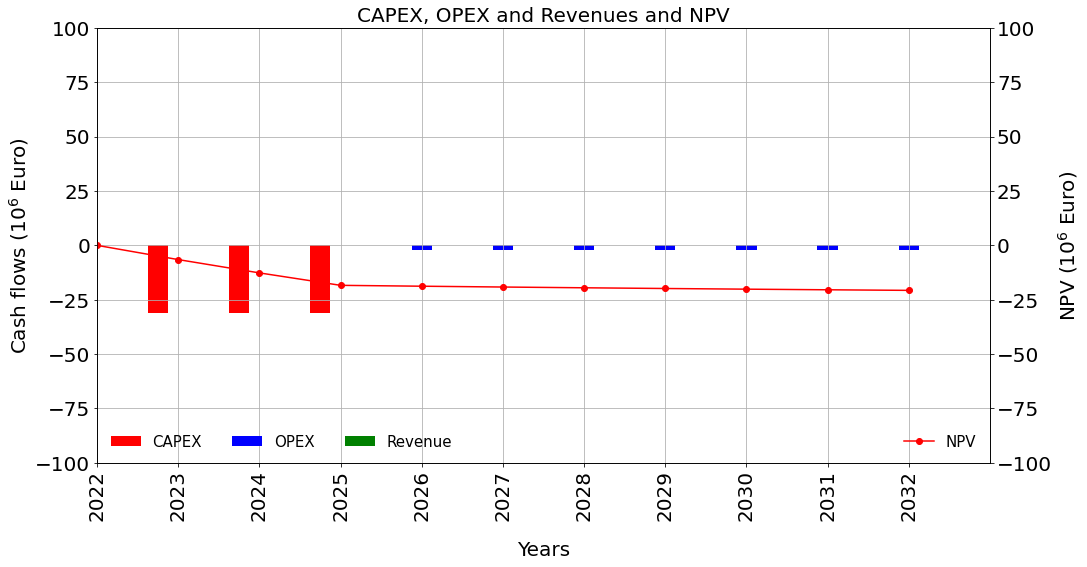

In [7]:
df_Foundations = Inputs_2_cashflow(Inputs, startyear=2022, lifecycle=11, component='Foundations',Debug=True)
df_npv_Foundations = calculate_npv(df_Foundations)
create_npv_plot(df_npv_Foundations, cash_flow_lims=[-100,100], npv_lims=[-100,100])

'Construction items Turbines: 80 units'

'CAPEX component Turbines: 904000000 eu for 80 unit(s)'

'Construction duration Turbines: 3 years'

'Construction allocation Turbines: [0.4, 0.3, 0.3] per year'

'OPEX component Turbines: 27120000.0 eu for 80 unit(s)'

'Revenue Turbines: 0 euro/unit'

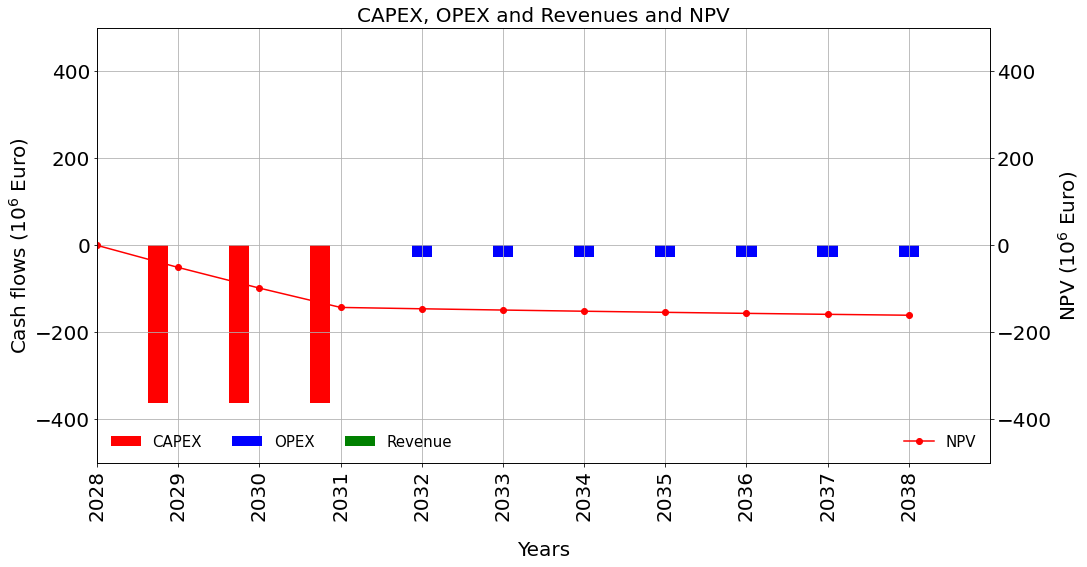

In [8]:
df_Turbines = Inputs_2_cashflow(Inputs, startyear=2028, lifecycle=11, component='Turbines',Debug=True)
df_npv_Turbines = calculate_npv(df_Turbines)
create_npv_plot(df_Turbines, cash_flow_lims=[-500,500], npv_lims=[-500,500])

##### B. combine two items

In [9]:
df_Foundations = Inputs_2_cashflow(Inputs, startyear=2022, lifecycle=11, component='Foundations',Debug=False)
df_Turbines = Inputs_2_cashflow(Inputs, startyear=2028, lifecycle=11, component='Turbines',Debug=False)
df_combined = combine_cashflow_dataframes([df_Foundations, df_Turbines])

In [10]:
df_npv_combined = calculate_npv(df_combined)

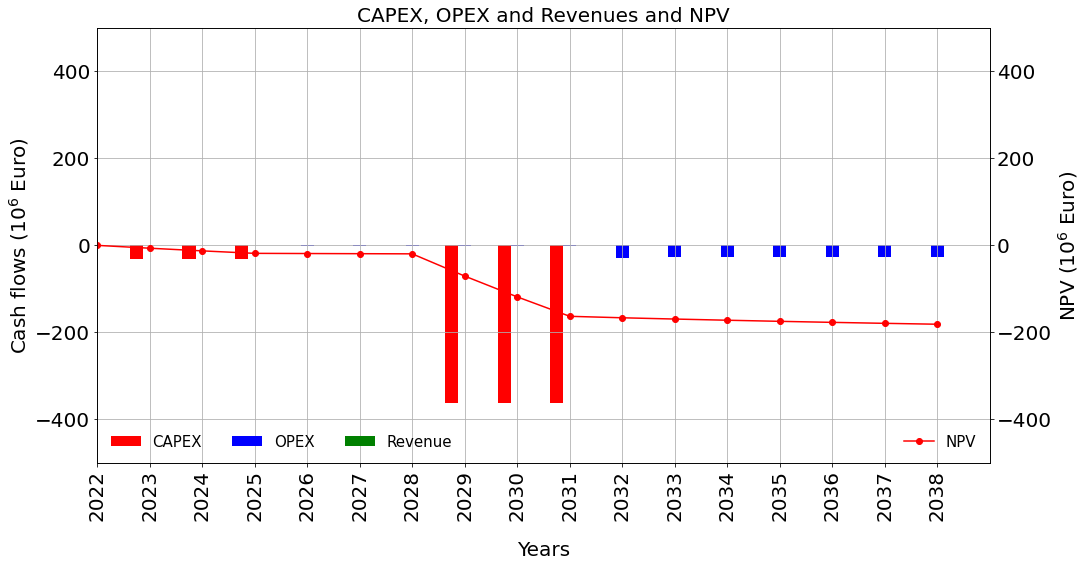

In [11]:
create_npv_plot(df_npv_combined, cash_flow_lims=[-500,500], npv_lims=[-500,500])